In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from glob import glob
from skimage import io
import os
import matplotlib
from scipy.interpolate import CubicSpline

matplotlib.rcParams.update({'errorbar.capsize': 4})


In [173]:
filtAv = [438, 472, 549, 575, 586, 605, 631, 661, 676, 692]
filtUn = np.array([28, 35, 21, 35, 26, 22, 28, 26, 29, 47]) / 2
filtQE = np.array([0.52654585, 0.61510198, 0.67157561, 0.70026282, 0.71884383, 0.7279477, 0.72530424, 0.71414267, 0.68976776, 0.6438945])

ROOTPATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/'

In [111]:
def prepare_spectrum(files, roi):
    nfilt = len(files)
    
    imdark = io.imread(files[-1]).astype(np.int64)
    # img = io.imread(files[0]).astype(np.int64)
    imroi = imdark[roi[0]:roi[1], roi[2]:roi[3]]
    roiSize = imroi.shape[0] * imroi.shape[1]
    offset = 100 * roiSize

    avInt = []
    unInt = []
    for i in range(nfilt-2):
        im = io.imread(files[i]).astype(np.int64)
        img = im - imdark
        imroi = img[roi[0]:roi[1], roi[2]:roi[3]]
        intPx = (imroi.sum() - offset) / roiSize
        avInt.append(intPx)
        
        unPx = np.sqrt((imroi**2).sum()) / roiSize
        unInt.append(unPx)

    avInt = np.array(avInt)
    unInt = np.array(unInt)
    cntQe = avInt / filtQE
    cntQe /= (filtUn*2)

    unInt /= filtQE
    unInt /= (filtUn*2)


    return cntQe, unInt

def plot_spectrum(path, roi, label = None):
    if label == None:
        label = os.path.split(path)[1]
    files = glob(path+'/*.tif')
    files.sort()
    ct, unt = prepare_spectrum(files, roi)

    plt.errorbar(x = filtAv, xerr=filtUn, y = ct, yerr=unt, fmt='o-', label=label)

    plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$')
    plt.legend()
    return ct, unt

# Plot reference spectrum

### Sources
H. Du, R. A. Fuh, J. Li, A. Corkan, J. S. Lindsey, "PhotochemCAD: A computer-aided design and research tool in photochemistry," Photochem. Photobiol., 68, 141-142, 1998. 

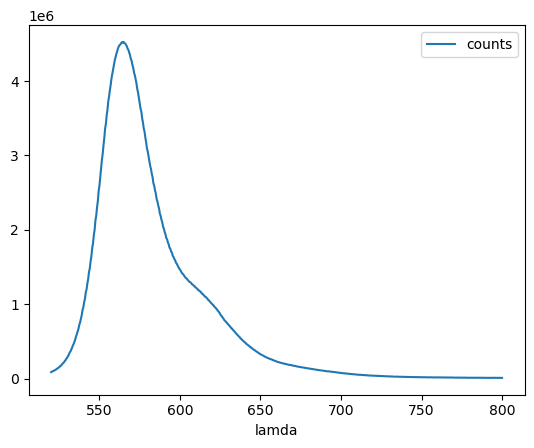

In [71]:
file_em = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectra/emission/Rhodamine-B/Rhodamine_B_emission.txt'
emdf = pd.read_csv(file_em, sep='\t', skiprows=13, names=['lamda', 'counts'])
emdf = emdf.iloc[:-1]
emdf['lamda'] = emdf['lamda'].astype('float')
emdf = emdf.set_index('lamda')
emdf.plot()

### Extend to 400 nm

In [133]:
intensity = emdf['counts'].loc[wavelength].values
len(intensity), len(wavelength)

(60, 60)

Extrapolated intensity at 500 nm (should be 0): 0.7925930351950045


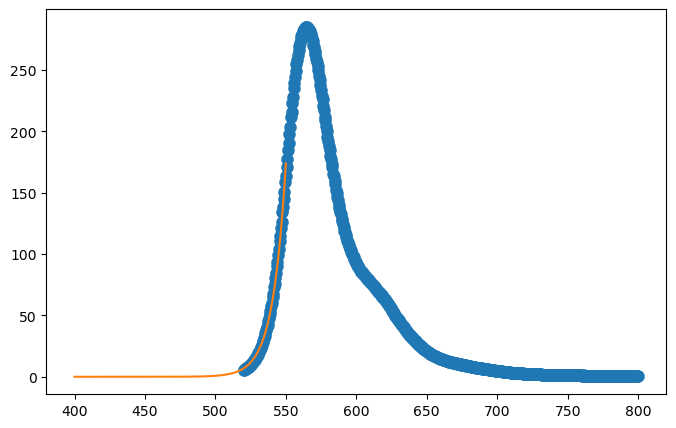

In [144]:
from scipy.optimize import curve_fit

# Sample data (replace with actual data)
wavelength = emdf.index[emdf.index < 550]
intensity = emdf['counts'].loc[wavelength].values

# Define a shifted logarithmic function for fitting, ensuring I(500) = 0
def exp_fit(x, A, B):
    return A * np.exp(B * (x - 400))

# Fit the exponential function to the data
params, _ = curve_fit(exp_fit, wavelength, intensity, p0=[1, 0.1])  # Initial guess for A and B

# Generate values for extrapolation from 500 nm to 550 nm
wavelength_extrapolated = np.linspace(400, 550, 200)
intensity_extrapolated = exp_fit(wavelength_extrapolated, *params)

# Predict intensity at 500 nm
intensity_500 = exp_fit(500, *params)
print(f"Extrapolated intensity at 500 nm (should be 0): {intensity_500}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(emdf, 'o', label="Original Data", markersize=8)
plt.plot(wavelength_extrapolated, intensity_extrapolated, '-', label="Logarithmic Fit (Extrapolated)")


In [160]:
dfext = pd.DataFrame(intensity_extrapolated[wavelength_extrapolated < 520], index=wavelength_extrapolated[wavelength_extrapolated < 520], columns=['counts'])
emext = pd.concat([dfext, emdf])

# Compare to low power data

### Import data

In [189]:
roi = [1, 2024, 1, 2024]
path_diode = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/1'   # Diode laser data
path_topt = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/2'    # TOptica laser data
files = glob(path_topt+'/*.tif')
files.sort()
ct, unt = prepare_spectrum(files, roi)

### Scale spectrum

In [199]:
scale_factor = np.max(emext['counts']) / np.max(ct)
emext['counts'] = emext['counts'] / scale_factor

### Plot 

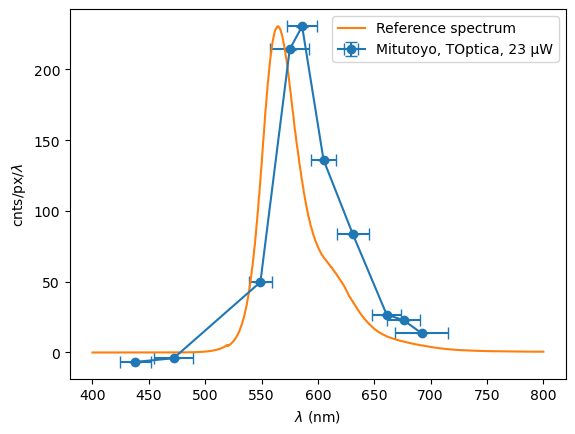

In [200]:
roi = [1, 2024, 1, 2024]
path_diode = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/1'   # Diode laser data
path_topt = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/2'    # TOptica laser data

ct, uct = plot_spectrum(path_topt, roi, label='Mitutoyo, TOptica, 23 µW')
plt.gca().plot(emext, label='Reference spectrum')
plt.legend()

### Bin values in the continuous spectrum

In [187]:
def bin_values(emext):
    binned_values = []
    for center, width in zip(filtAv, filtUn):
        λ_min, λ_max = center - width, center + width
        
        # Select values in range using index
        filtered_counts = emext.loc[λ_min:λ_max, "counts"]
        
        if not filtered_counts.empty:
            avg_counts = filtered_counts.mean()  # Average over the range
        else:
            avg_counts = np.nan  # No data in range
        
        binned_values.append(avg_counts)

    binned_values = np.array(binned_values)
    return binned_values

In [201]:
binned_20uw = bin_values(emext)

[Text(0, 0.5, 'cnts/px/$\\lambda$'), Text(0.5, 0, '$\\lambda$ (nm)')]

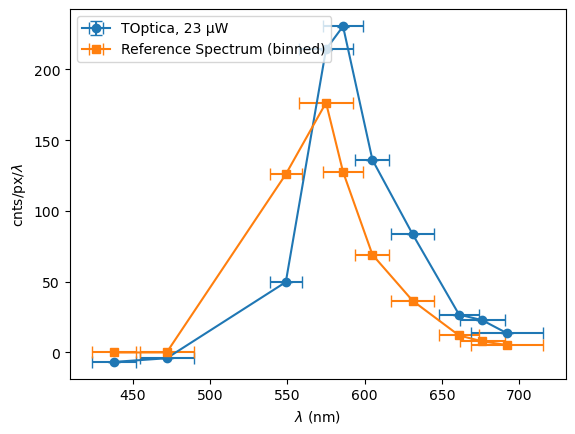

In [202]:
plt.errorbar(filtAv, ct, xerr=filtUn, yerr=uct, fmt='o-', label="TOptica, 23 µW")
plt.errorbar(filtAv, binned_20uw, xerr=filtUn, fmt='s-', label="Reference Spectrum (binned)")
plt.legend()
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$')

# Compare to high power data

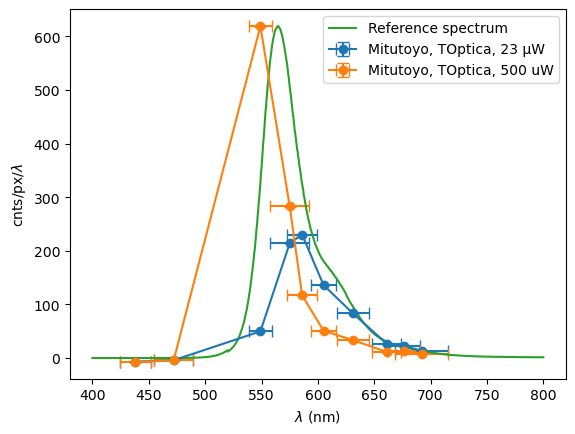

In [203]:
roi = [1, 2024, 1, 2024]

path_1mw = ROOTPATH + 'sets/16-02-25/Rhodamine-B 50 µM/1'   # At 1 mW
path_500uw = ROOTPATH + 'sets/16-02-25/Rhodamine-B 50 µM/2'   # At 500 mW

# ct1, uct1 = plot_spectrum(path_1mw, roi, label='Mitutoyo, TOptica, 1 mW')
ct0, uct0 = plot_spectrum(path_topt, roi, label='Mitutoyo, TOptica, 23 µW')
ct, uct = plot_spectrum(path_500uw, roi, label='Mitutoyo, TOptica, 500 uW')

scale_factor = np.max(emext['counts']) / np.max(ct)
emext['counts'] = emext['counts'] / scale_factor
plt.gca().plot(emext, label='Reference spectrum')
plt.legend()

In [204]:
binned_1mw = bin_values(emext)

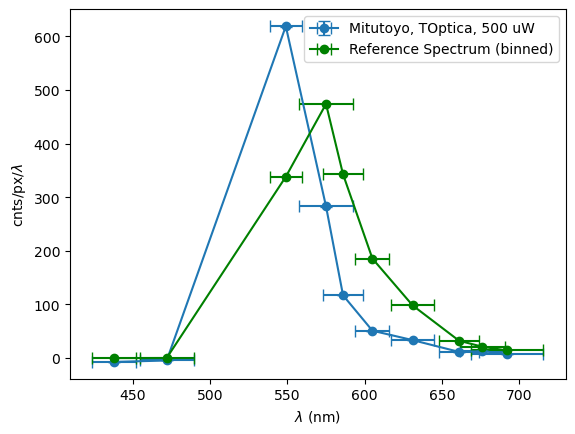

In [208]:
# ct0, uct0 = plot_spectrum(path_topt, roi, label='Mitutoyo, TOptica, 23 µW')
ct, uct = plot_spectrum(path_500uw, roi, label='Mitutoyo, TOptica, 500 uW')
plt.errorbar(filtAv, binned_1mw, xerr=filtUn, fmt='go-', label="Reference Spectrum (binned)")
plt.legend()